<a href="https://colab.research.google.com/github/mashinakatherina/Big-Data-analysis-and-training/blob/trunk/PySpark_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apache Spark и PySpark
*Apache Spark* был создан для быстрого анализа больших данных. Одной из важных функций, которые предлагает Apache Spark, является возможность выполнять вычисления в памяти. Он также считается более эффективным по сравнению с *MapReduce* для сложных приложений, работающих на Диске.

Spark обеспечивает высокую доступность, предлагая простые API-интерфейсы на Python, Java, Scala и SQL, а также богатые встроенные библиотеки. Он также тесно интегрируется с другими инструментами больших данных. В частности, Spark может работать в кластерах Hadoop и получать доступ к любому источнику данных Hadoop, включая Cassandra.

*PySpark* - это интерфейс, обеспечивающий доступ к Spark с помощью языка программирования Python. PySpark может использоваться для распределенных вычислений на Python в рамках анализа и обработки больших данных, а также машинного обучения.<br/>
PySpark взаимодействует с самим Spark через специальную библиотеку [Py4J](https://www.py4j.org/). Она позволяет программам Python, которые выполняются интерпретатором, динамически обращаться к объектам Java в JVM, транслируя код Scala в JVM. Для большей совместимости PySpark поддерживает парадигму функционального программирования, т.к., во-первых, язык Scala является функциональным, во-вторых, функциональный код намного проще распараллелить. Таким образом, PySpark позволяет проводить параллельную обработку без необходимости использования каких-либо модулей Python для потоковой или многопроцессорной обработки. Вся сложная коммуникация и синхронизация между потоками, процессами и даже разными CPU обрабатываются в Spark.

Чтобы запустить Spark в Google Colab, сначала необходимо установить все зависимости, такие как Apache Spark с Hadoop и платформу Java. В качестве платформы Java можно взять свободный JDK (Java development kit), актуальны версии 8+. Ссылка для скачивания Apache Spark доступна на главной странице [Apache Software Foundation](https://www.apache.org/) на вкладке Downloads. Скачанный архив нужно разархивировать командой `tar`. Установка инструментов может быть выполнена внутри Jupyter Notebook в Colab.

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz

После этого в окружение среды нужно указать пути *JAVA_HOME* и *SPARK_HOME* на скачанные программы. Поскольку Spark загружен напрямую, он находится в директории *content*. Воспользуемся модулем `os`, который предоставляет интерфейс для взаимодействия с файловой системой.

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

Чтобы использовать PySpark как обычную Python-библиотеку, дополнительно необходимо установить `findspark`:

In [ ]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Далее необходимо проинициализировать PySpark. Для этого вызывается метод `findspark.init()`, затем создаётся точка входа кластера. Для этого, в первую очередь, Spark создает S*parkContext* — объект, который определяет, как получить доступ к кластеру в момент выполнения программы. Также через *SparkConf* определяются параметры конфигурации. К ним может относиться кластерный менеджер (master), с которым соединяется приложение через URL (т.е. каким образом следует подключиться — локально, к Kubernates или YARN и т.д.), название приложения, количество выделяемых ядер и т.д. (с полным списком можно ознакомиться в [документации](https://spark.apache.org/docs/latest/configuration.html)). Начиная со Spark 2.0, единой точкой входа в Spark-приложение является *SparkSession*, что устраняет необходимость явно создавать *SparkConf* и *SparkContext*, поскольку они инкапсулируются в *SparkSession*. Все функции, которые были доступны в *SparkContext*, доступны и в *SparkSession*.

In [ ]:
import findspark 
findspark.init() 
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Теперь Colab готов запускать PySpark.

#Pandas и PySpark

Интерфейс *PySpark* во многом похож на интерфейс *Pandas*. В частности, оба используют DataFrame для представления табличных данных, отсюда следует использование множества схожих методов. При разных названиях, они также пересекаются с операциями SQL, например, методы `distinct`, `where` в PySpark соответствуют методам `unique`, `filter` в Pandas.<br/>
Главное отличие между PySpark и Pandas состоит в режиме выполнения. PySpark реализует *lazy execution* (ленивое выполнение), в то время как Pandas — *eager execution* (мгновенное выполнение). Например, требуется загрузить данные на диске и применить к ним операции трансформации (map). Pandas выполнит их тут же. PySpark же сохранит всю последовательность необходимых операций и выполнит их в том случае, когда данные понадобятся.<br/>
Существует возможность довольно просто перейти от PySpark к Pandas и наоборот:
```
# Из Pandas в PySpark 
spark_df = spark.createDataFrame(pandasDF)

# Из PySpark в Pandas 
pandasDF = spark_df.toPandas()
```




#Доступные в PySpark форматы для чтения и записи
PySpark поддерживает такие основные форматы, как CSV, JSON, ORC, Parquet. 
Ниже приведены примеры синтаксиса чтения и записи, который практически одинаков для всех форматов.<br/>

*   CSV (Comma-separated values, значения, разделенные запятыми) — наиболее часто используемый формат для хранения датасетов: 
```
data = spark.read.csv(“file.csv”) # прочитать
data.write.csv(”file_dir”, sep=',') # записать
```






*  JSON (JavaScript Object Notation) применяется для сериализации данных, используется также в MongoDB: 
```
data = spark.read.json(“file.json”)
data.write.json(”file_dir”)
```
*  ORC (Optimized Row Columnar) — формат хранения данных экосистем Apache Hadoop: 
```
data = spark.read.orc(“orc_file”)
data.write.orc()
```
*   Parquet- еще один формат экосистем Apache Hadoop, который может изменяться в соответствии с изменением данных, а также поддерживает слияние схем: 
```
data = spark.read.parquet(“parquet_file”)
data.write.parquet(”file_dir”)
```
PySpark также поддерживает функциональный стиль программирования. Например, чтение CSV-файла в этом случае будет выглядеть следующим образом:
```
data = spark.read \
    .format(“json”) \
    .load(“file.json”) \
    .option("header", True)
```













In [ ]:
# Загрузка данных в Spark DataFrame
# df = spark.read.option('header', True).csv("daily_weather.csv")
df = spark.read.load("daily_weather.csv", 
                      format='com.databricks.spark.csv', 
                      header='true',inferSchema='true') # третий аргумент указывает, что первая строка является заголовком, четвертый аргумент указывает на вывод типов данных

В pyspark датафреймы подсчитываются лениво. При запуске команды pyspark не прозводит вычисления сразу, а лишь планирует их на будущее. Все запланированные вычисления производятся, когда данные действительно понадобятся, при запуске команд-действий, таких как collect(), take() и др.

In [ ]:
df.show()

In [ ]:
df.columns # просмотреть столбцы

['number',
 'air_pressure_9am',
 'air_temp_9am',
 'avg_wind_direction_9am',
 'avg_wind_speed_9am',
 'max_wind_direction_9am',
 'max_wind_speed_9am',
 'rain_accumulation_9am',
 'rain_duration_9am',
 'relative_humidity_9am',
 'relative_humidity_3pm']

In [ ]:
df.printSchema() # вывод типов данных столбцов

root
 |-- number: integer (nullable = true)
 |-- air_pressure_9am: double (nullable = true)
 |-- air_temp_9am: double (nullable = true)
 |-- avg_wind_direction_9am: double (nullable = true)
 |-- avg_wind_speed_9am: double (nullable = true)
 |-- max_wind_direction_9am: double (nullable = true)
 |-- max_wind_speed_9am: double (nullable = true)
 |-- rain_accumulation_9am: double (nullable = true)
 |-- rain_duration_9am: double (nullable = true)
 |-- relative_humidity_9am: double (nullable = true)
 |-- relative_humidity_3pm: double (nullable = true)



In [ ]:
df.describe().toPandas().transpose() # сводная статистика по датафрейму

In [ ]:
df.describe(['air_temp_9am']).show() # сводная статистика по отдельному столбцу

+-------+------------------+
|summary|      air_temp_9am|
+-------+------------------+
|  count|              1090|
|   mean| 64.93300141287072|
| stddev|11.175514003175877|
|    min|36.752000000000685|
|    max| 98.90599999999992|
+-------+------------------+



In [ ]:
len(df.columns) # количество столбцов 

11

In [ ]:
df.count() # количество строк

1095

Количество строк в датафрейме равно 1095, но сводная статистика по air_pressure_9am показывает, что в данном столбце всего 1090 строк. Это означает, что в данном столбце имеется 1095 - 1090 = 5 строк с пропущенными значениями.

In [ ]:
# удалим строки с пропущенными значениями в столбце air_pressure_9am
df2=df.na.drop(subset=['air_temp_9am'])

Посмотрим на общее количество строк:

In [ ]:
df2.count()

1090

Количество строк в датафрейме и столбце теперь совпадает.

**Заполнение пропущенных значений**. Вместо удаления строк, содержащих пропущенные значения, можно заменить их средними или медианными значениями для данного столбца. <br/>
Сначала загрузим функцию *avg* и сделаем копию исходного DataFrame:

In [ ]:
from pyspark.sql.functions import avg

imputeDF = df

Далее проведем итерацию по каждому столбцу: вычислим среднее значение для данного столбца, а затем заменим все отсутствующие значения в этом столбце средним значением.

In [ ]:
for x in imputeDF.columns:
    meanValue = df2.agg(avg(x)).first()[0]
    print(x, meanValue)
    imputeDF = imputeDF.na.fill(meanValue, [x])

number 546.8256880733945
air_pressure_9am 918.8833281182478
air_temp_9am 64.93300141287072
avg_wind_direction_9am 142.19559679647966
avg_wind_speed_9am 5.516615074808091
max_wind_direction_9am 148.87405226312185
max_wind_speed_9am 7.030251646918073
rain_accumulation_9am 0.20401566328648446
rain_duration_9am 295.460895202365
relative_humidity_9am 34.286931549494355
relative_humidity_3pm 35.37023074361628


In [ ]:
df.describe(['air_temp_9am']).show()
imputeDF.describe(['air_temp_9am']).show()

+-------+------------------+
|summary|      air_temp_9am|
+-------+------------------+
|  count|              1090|
|   mean| 64.93300141287072|
| stddev|11.175514003175877|
|    min|36.752000000000685|
|    max| 98.90599999999992|
+-------+------------------+

+-------+------------------+
|summary|      air_temp_9am|
+-------+------------------+
|  count|              1095|
|   mean| 64.93300141287071|
| stddev|11.149946561759078|
|    min|36.752000000000685|
|    max| 98.90599999999992|
+-------+------------------+



Попробуйте заменить пропущенные значения на медиану и на техническую категорию (константу). Постройте распределенние для переменной (гистограмму) и сделайте вывод, какой из методов заполнения в данном случае лучше.

In [ ]:
# Ваш код

**Коррелированные переменные** - присутствие в наборе данных линейно зависимых признаков.<br/>
Корреляцию между двумя столбцами можно подсчитать иcпользуя метод `corr()`. Для примера рассчитаем корреляцию между rain_accumulation_9am и rain_duration_9am:

In [ ]:
df2.stat.corr("rain_accumulation_9am", "rain_duration_9am")

0.7337737589869374

**Обработка категориальных признаков.**<br/>
Данные для обработки и их описание можно скачать по ссылке: https://www.kaggle.com/c/ieee-fraud-detection



In [ ]:
# Label encoding - замена текстового представления признака на числовое

# One-hot encoding


**Масштабирование переменных** требуется в случае, когда один из признаков принимает очень большие значения по сравнению со значениями других признаков. Существуют различные способы масштабирования.<br/>
1. **z-нормализация** <br/>
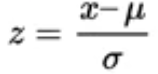 <br/>
где mu - среднее значение, sigma - среднеквадическое отклонение.<br/>

2. **Минимакс масштабирование**<br/>
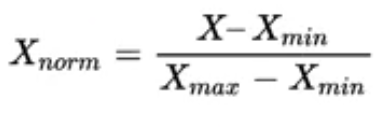

In [ ]:
# Ваш код

**Выбросы** (нетипичные наблюдения)<br/>
1. Ящик с усами (boxplot)
2. Точечные диаграммы (scatter plot)
3. Z-оценка (z-score)

**Ошибки разметки, дубликаты, шумы**.<br/>
Данные для анализа: https://www.kaggle.com/c/shopee-product-matching